## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [1]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import matplotlib.colors as colors

# feems
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import * #plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges


# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [2]:
n_rows, n_columns = 8, 16
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5)

lrn = [(36,91)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_startpt=5.5, barrier_endpt=5.5,barrier_w=1.0, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.])

gen_test_1e = simulate_genotypes(graph, target_n_snps=500, n_print=150)

Simulating ~SNP 0
Simulating ~SNP 150
Simulating ~SNP 300
Simulating ~SNP 450


In [67]:
## fit_cov = obj.Linv_block['oo'] - 1/d + sp_graph.q_inv_diag.toarray()
# sp_Graph_def_jt = Joint_SpatialGraph(gen_test_1e, coord, grid, edge_def)
# sp_Graph_def_jt.fit(lamb=30., optimize_q='n-dim')
# obj_jt = Joint_Objective(sp_Graph_def_jt); obj_jt.inv(); obj_jt.inv(reg=False)
obj_jt.Linv_block["oo"]

array([[ 0.75732535,  0.44823031,  0.29729638, ..., -0.12856687,
        -0.13472384, -0.13788606],
       [ 0.44823031,  0.53056723,  0.32668661, ..., -0.12547283,
        -0.13161607, -0.13477394],
       [ 0.29729638,  0.32668661,  0.45004244, ..., -0.11937755,
        -0.12547732, -0.1286214 ],
       ...,
       [-0.12856687, -0.12547283, -0.11937755, ...,  0.4176743 ,
         0.30459395,  0.27697804],
       [-0.13472384, -0.13161607, -0.12547732, ...,  0.30459395,
         0.49622678,  0.41770609],
       [-0.13788606, -0.13477394, -0.1286214 , ...,  0.27697804,
         0.41770609,  0.72337229]])

In [9]:
def get_best_lre(sp_graph_lr, gen_test, coord, grid, edge_def, k=5, nfolds=None, lamb_cv=3., top=20):
    sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
    edges_lr = deepcopy(edge_def)
    edges_lr = edges_lr.tolist()
    ll_edges = np.empty((top,k))
    top_edges = pd.DataFrame(index=range(top), columns=range(k))
    for ik in range(k):
        print("Starting search for edge {}...".format(ik+1))
        lrn = comp_genetic_vs_fitted_distance(sp_graph_lr, n_lre=top, lamb=lamb_cv, plotFig=False, joint=True)
        # lrn = list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)].values.reshape(top,2)))
        edges_lr.append(list(x+1 for x in lrn[0]))
        # print(len(edges_lr))
        sp_graph_lr = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=lrn[0:1])
        sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2),verbose=False)
        # print(len(sp_graph_lr.edges))
        obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); 
        ll_edges[0,ik] = -obj_lr.neg_log_lik()
        for ie, e in enumerate(lrn[1:]):
            ll_edges[ie+1,ik] = sub_edge_get_ll(sp_graph_lr, lrn[ie], lrn[ie+1], 3.)
        print("{}, found at index {}.".format(lrn[np.argmax(ll_edges[:,ik])], np.argmax(ll_edges[:,ik])))
        top_edges.iloc[:,ik] = lrn
        sub_edge_get_ll(sp_graph_lr, lrn[len(lrn)-1], lrn[np.argmax(ll_edges[:,ik])], 3.)
        edges_lr = [list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]) if item == list(x+1 for x in lrn[0]) else item for item in edges_lr] 
        # print(len(edges_lr))
        # print(lrn, ll_edges[:,ik])
        # edges_lr.append(list(x+1 for x in lrn[np.argmax(ll_edges[:,ik])]))
        # sp_graph = Joint_SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[lrn[np.argmax(ll_edges[:,ik])]])
        sp_graph_lr.fit(lamb=lamb_cv, optimize_q='n-dim', lamb_q=1., alpha_q=1./np.mean(sp_graph_lr.s2))
        
    return ll_edges, top_edges

In [156]:
# comp_genetic_vs_fitted_distance(sp_Graph_def_jt, n_lre=10, lamb=3., plotFig=False, joint=True)
# get_best_lre(sp_Graph_def_jt,gen_test_1e,coord,grid,edge_def,top=10,k=2) -> (36,91) found as TRUE EDGE!
# edges_lr = deepcopy(edge_def)
# edges_lr = edges_lr.tolist()
# edges_lr.append(list(x+1 for x in (36,91)))
sp_graph_lr = Joint_SpatialGraph(gen_test_1e, coord, grid, np.array(edges_lr), long_range_edges=[(36,91)])
sp_graph_lr.fit(lamb=3.,optimize_q='n-dim',lamb_q=1.,alpha_q=1.)
obj_lr = Joint_Objective(sp_graph_lr); obj_lr.inv(); obj_lr.grad(reg=False)
## under different values of c (no c: 0.0155325646206505, c=1: 0.015532564620648085, c=0.9: 0.038757811606089126, c=0.5: 0.13466990207650034, c=0.1: 0.229581157859927, c=0: 0.25213769340591785)
print(obj_lr.Linv_block["oo"][36,91], sp_graph_lr.w[sp_graph_lr.lre_idx])

constant-w/variance fit, converged in 119 iterations, train_loss=3329.5580693
lambda=3.0000000, alpha=0.6540561, converged in 8 iterations, train_loss=1029.4587428
0.015647570126622327 [2.05488007]


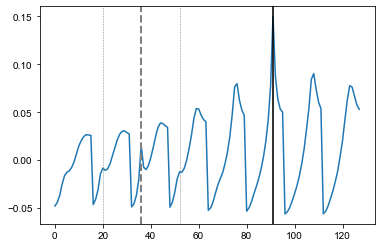

In [118]:
## given we know the edge, can we estimate the correct edge weight?
# obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][1]], obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][0]], obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][1],obj_lr.sp_graph.lre[0][0]]
# plt.hist(np.diag(obj_lr.Linv_block["oo"]),20); plt.axvline(obj_lr.Linv_block["oo"][obj_lr.sp_graph.lre[0][0],obj_lr.sp_graph.lre[0][0]],ls='--',color='k')
plt.plot(obj_lr.Linv_block["oo"][36,:]); plt.axvline(36,color='k',linewidth=2,alpha=0.8); plt.axvline(91,ls='--',color='grey',linewidth=2); plt.axvline(75,ls='--',color='grey',linewidth=0.5);plt.axvline(107,ls='--',color='grey',linewidth=0.5);
# plt.plot(obj_lr.Linv_block["oo"][41,:]); plt.axvline(41,color='k',alpha=0.8);
# plt.imshow(obj_lr.Linv_block["oo"])
# fit_cov, _, emp_cov = comp_mats(obj_lr)
# plt.imshow(emp_cov-obj_lr.Linv_block["oo"])

In [129]:
[np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*np.dot(sp_graph_lr.adj_base.todense()[36,:],obj_lr.Linv_block["oo"][:,36])[0])[0] for c in cc]

[0.24557120617524647,
 0.24087654002107103,
 0.2361818738668956,
 0.2314872077127202,
 0.22679254155854478,
 0.22209787540436934,
 0.2174032092501939,
 0.2127085430960185,
 0.20801387694184306,
 0.20331921078766763,
 0.1986245446334922,
 0.19392987847931678,
 0.18923521232514134,
 0.1845405461709659,
 0.17984588001679047,
 0.17515121386261506,
 0.17045654770843963,
 0.1657618815542642,
 0.16106721540008878,
 0.15637254924591334,
 0.1516778830917379,
 0.14698321693756247,
 0.14228855078338706,
 0.13759388462921163,
 0.1328992184750362,
 0.12820455232086078,
 0.12350988616668536,
 0.11881522001250994,
 0.1141205538583345,
 0.10942588770415906,
 0.10473122154998366,
 0.10003655539580822,
 0.09534188924163278,
 0.09064722308745735,
 0.08595255693328192,
 0.08125789077910651,
 0.07656322462493108,
 0.07186855847075564,
 0.06717389231658022,
 0.06247922616240481,
 0.057784560008229374,
 0.05308989385405394,
 0.04839522769987851,
 0.04370056154570307,
 0.03900589539152766,
 0.0343112292373522

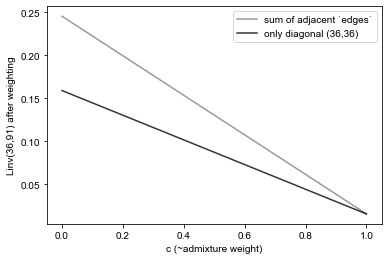

In [150]:
# cc = np.linspace(0,1,50)
plt.plot(cc,[np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*np.dot(sp_graph_lr.adj_base.todense()[36,:],obj_lr.Linv_block["oo"][:,36])[0])[0] for c in cc],color='grey',alpha=0.8,label='sum of adjacent `edges`'); plt.xlabel('c (~admixture weight)'); plt.ylabel('Linv(36,91) after weighting'); 
plt.plot(cc,[np.ravel(c*obj_lr.Linv_block["oo"][36,91]+(1-c)*obj_lr.Linv_block["oo"][36,36])[0] for c in cc],color='k',alpha=0.8, label='only diagonal (36,36)'); plt.legend()
# plt.axvline()
# obj_lr.Linv_block["oo"][36,91]

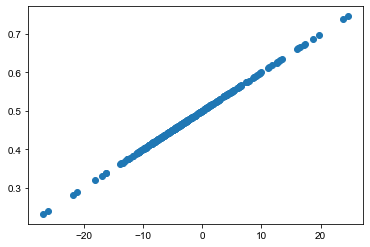

In [180]:
# plt.scatter(sp_Graph_def_jt.w,sp_graph_lr.w[~sp_graph_lr.lre_idx],color='grey',alpha=0.8)
# import matplotlib.colors as clr
# foldchange = (sp_graph_lr.w[~sp_graph_lr.lre_idx]-sp_Graph_def_jt.w)*100/sp_Graph_def_jt.w
# change_norm = clr.CenteredNorm(halfrange=50)
plt.scatter(foldchange, change_norm(foldchange))

In [242]:
# plt.hist(clr.CenteredNorm(0.05)(np.log10(sp_Graph_def_jt.w) - np.mean(np.log10(sp_Graph_def_jt.w))),20)
# v.edge_cmap(change_norm(foldchange)).shape, v.edge_cmap(clr.LogNorm(0.01,100.,)(sp_Graph_def_jt.w)).shape
# plt.plot(foldchange,color=change_norm(foldchange))
# list(np.column_stack(self.idx))

masked_array(data=[0.43194791, 0.61819896, 0.53753407, 0.54766063,
                   0.54072434, 0.36556934, 0.55109406, 0.5952391 ,
                   0.48273359, 0.36071595],
             mask=False,
       fill_value=1e+20)

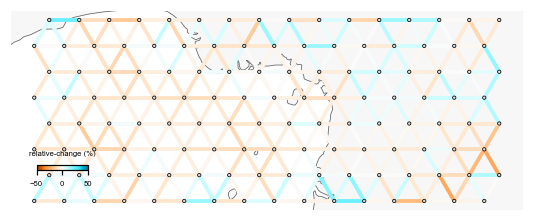

In [266]:
fig = plt.figure(dpi=110) 
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_Graph_def_jt, projection=projection, edge_width=2.5, #weights=np.random.rand(len(sp_Graph_def_jt.w)),
        edge_alpha=1, edge_zorder=100, sample_pt_size=2, foldchange=foldchange,
        obs_node_size=1.5, sample_pt_color="black", cbar_ticklabelsize=5,
        cbar_font_size=5, cbar_width='10%',cbar_height='2.5%')
v.draw_map()
v.draw_edges(use_weights=True, use_foldchange=True)
v.draw_obs_nodes()
# v.draw_edge_colorbar()
v.draw_edge_change_colorbar()

In [260]:
# plt.scatter(v.norm_log_weights, v.foldchange)
# len(v.foldchange), len(v.norm_log_weights)
# len(recover_nnz_entries(sp_Graph_def_jt))
# plt.scatter(recover_nnz_entries(sp_Graph_def_jt)[:337],recover_nnz_entries(sp_Graph_def_jt)[337:])
list(sp_Graph_def_jt.edges), list(sp_graph_lr.edges)

([(0, 1),
  (0, 16),
  (1, 2),
  (1, 17),
  (1, 16),
  (2, 3),
  (2, 18),
  (2, 17),
  (3, 4),
  (3, 19),
  (3, 18),
  (4, 5),
  (4, 20),
  (4, 19),
  (5, 6),
  (5, 21),
  (5, 20),
  (6, 7),
  (6, 22),
  (6, 21),
  (7, 8),
  (7, 23),
  (7, 22),
  (8, 9),
  (8, 24),
  (8, 23),
  (9, 10),
  (9, 25),
  (9, 24),
  (10, 11),
  (10, 26),
  (10, 25),
  (11, 12),
  (11, 27),
  (11, 26),
  (12, 13),
  (12, 28),
  (12, 27),
  (13, 14),
  (13, 29),
  (13, 28),
  (14, 15),
  (14, 30),
  (14, 29),
  (15, 31),
  (15, 30),
  (16, 17),
  (16, 32),
  (16, 33),
  (17, 18),
  (17, 33),
  (17, 34),
  (18, 19),
  (18, 34),
  (18, 35),
  (19, 20),
  (19, 35),
  (19, 36),
  (20, 21),
  (20, 36),
  (20, 37),
  (21, 22),
  (21, 37),
  (21, 38),
  (22, 23),
  (22, 38),
  (22, 39),
  (23, 24),
  (23, 39),
  (23, 40),
  (24, 25),
  (24, 40),
  (24, 41),
  (25, 26),
  (25, 41),
  (25, 42),
  (26, 27),
  (26, 42),
  (26, 43),
  (27, 28),
  (27, 43),
  (27, 44),
  (28, 29),
  (28, 44),
  (28, 45),
  (29, 30),
  (29,

In [272]:
idx = list(sp_Graph_def_jt.edges).index((112,113))
foldchange[idx], sp_Graph_def_jt.w[idx], sp_graph_lr.w[~sp_graph_lr.lre_idx][idx]

(24.602030556300743, 2.5104853878117668, 2.0248185585927896)